# Вводная


**Повышение качества фото с помощью автокодировщика**

Работа выполнена студентом СибАДИ г.Омска

## Краткое описание проблемы
Проблема супер-разрешения (Super-Resolution, SR) заключается в восстановлении изображений высокого разрешения (HR) из низкого разрешения (LR). Это важно для медицины, спутниковой съемки, видеонаблюдения и других областей.

## Основные концепции
- **LR и HR изображения**: LR – уменьшенные версии исходных изображений, HR – оригинальные.
- **SR-сети**: Используются сверточные нейронные сети, такие как SRCNN, SRResNet, EDSR.
- **Перцептуальные потери**: Потери, основанные на признаках, а не только на пикселях, улучшают визуальное качество.
- **CBAM (Convolutional Block Attention Module)**: Добавляет внимание по каналам и пространству, усиливая значимые признаки.

## Схема архитектуры
- Вход: LR изображение
- Первичный свёрточный слой + PReLU
- Последовательность **Residual/CBAM блоков**
- Сумма с исходным выходом после остаточного блока
- Upsample через PixelShuffle
- Конечный свёрточный слой -> выход SR изображения

# Иморт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from PIL import Image
import os
from tqdm import tqdm

# Теория

## Существующие архитектуры

## 1. CNN-базированные модели (свёрточные сети)

Используют **свёрточные блоки** для восстановления деталей.

- **SRCNN (Super-Resolution CNN)**
  - Архитектура: 3 свёрточных слоя, прямое увеличение разрешения.
  - ➕ Простота, быстрый старт.  
  - ➖ Мало деталей, устаревшая для больших масштабов.

- **FSRCNN (Fast SRCNN)**
  - Улучшенная версия SRCNN с ускоренной обработкой.

- **VDSR (Very Deep Super Resolution)**
  - ~20 слоёв, использует остаточные соединения.
  - Обеспечивает более высокое качество восстановления.

---

## 2. Residual Networks (ResNet) и остаточные блоки

Используются для **глубоких сетей** без проблем затухающих градиентов.

- **EDSR (Enhanced Deep Super-Resolution Network)**
  - Построена на ResNet-блоках без нормализации.  
  - Отлично работает для ×2 и ×4.

- **RCAN (Residual Channel Attention Network)**
  - Добавляет **attention по каналам**, чтобы сеть фокусировалась на важных признаках.  
  - Хорошо работает на изображениях с текстурами.

---

## 3. GAN-базированные подходы (Generative Adversarial Networks)

Используют **генератор + дискриминатор** для фотореалистичных деталей.

- **SRGAN (Super-Resolution GAN)**
  - Генератор создаёт изображение высокого разрешения, дискриминатор оценивает реалистичность.  
  - Отлично восстанавливает текстуры, делает картинку «живой».

- **ESRGAN (Enhanced SRGAN)**
  - Улучшенная версия с **Residual-in-Residual Dense Block (RRDB)**.  
  - Одно из лучших решений для фото с деталями.

- **Real-ESRGAN**
  - Обучен на **реальных изображениях с шумом и артефактами**.  
  - Работает с фотографиями и сканами.

---

## 4. Transformer-базированные модели

Используют **attention** для глобального контекста.

- **SwinIR (Swin Transformer for Image Restoration)**
  - Основан на **Swin Transformer**.  
  - Универсален: супер-разрешение, шумоподавление, восстановление.

- **HAT (Hierarchical Attention Transformer)**
  - Использует **иерархическое внимание**.  
  - Ещё лучше на сложных текстурах и деталях.

---

## 5. Другие подходы

- **Denoising + SR**
  - Сначала подавление шума (например, **DnCNN, CBDNet**), затем увеличение разрешения.

- **DBPN (Deep Back-Projection Networks)**
  - Использует многократное проецирование между LR ↔ HR.  
  - Даёт отличную детализацию.


## Выбранная модель: SRResNet

- **Архитектура**  
  Основана на **Residual Blocks**, как ResNet, но адаптирована под супер-разрешение.  
  Включает: несколько `ResBlock` → **апскейлинг (PixelShuffle)** → выходное изображение.

- **Преимущества**  
  - Стабильное обучение.  
  - Хорошее восстановление текстур без артефактов.  
  - Более «чистое» изображение по сравнению с GAN-моделями.  
  - Проще в реализации и обучении, чем EDSR/RCAN.

- **Недостатки**  
  - Не генерирует полностью «фотореалистичные» детали (картинка иногда выглядит «плоской»).  
  - Восстанавливает хуже мелкие детали, чем ESRGAN/Real-ESRGAN.  

- **Почему выбрана**  
  SRResNet занимает **середину между простыми CNN и GAN-подходами**:  
  - Легче, чем сложные трансформеры (SwinIR, HAT).  
  - Стабильнее, чем GAN (нет риска артефактов).  
  - Даёт баланс между **качеством, стабильностью и сложностью реализации**.

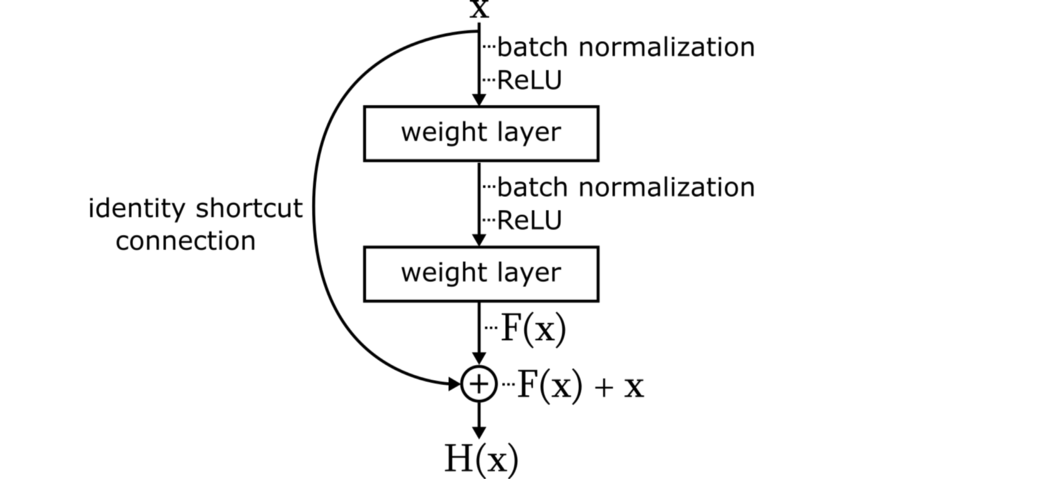

Архитектура простой ResNet

# Подготовка данных

In [ ]:
import kagglehub

path = kagglehub.dataset_download("soumikrakshit/div2k-high-resolution-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'div2k-high-resolution-images' dataset.
Path to dataset files: /kaggle/input/div2k-high-resolution-images


In [ ]:
!ls /kaggle/input/div2k-high-resolution-images

DIV2K_train_HR	DIV2K_valid_HR


In [ ]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, hr_size=516, scale=4):
        super().__init__()
        self.hr_dir = hr_dir
        self.hr_files = sorted(os.listdir(hr_dir))
        self.hr_size = hr_size
        self.scale = scale
        self.to_tensor = transforms.ToTensor()
        self.hr_transform = transforms.Resize((hr_size, hr_size), Image.BICUBIC)

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_dir, self.hr_files[idx])
        hr = Image.open(hr_path).convert("RGB")

        # ресайзим в фиксированный HR размер
        hr = self.hr_transform(hr)

        # создаем LR (сжимаем ×scale)
        lr_size = self.hr_size // self.scale
        lr = hr.resize((lr_size, lr_size), Image.BICUBIC)

        return self.to_tensor(lr), self.to_tensor(hr) # тобишь понижаем качество

In [ ]:
train_hr_dir = "/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR"

In [ ]:
dataset = DIV2KDataset(hr_dir=train_hr_dir, hr_size=512, scale=4)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

lr, hr = next(iter(dataloader))
print("LR shape:", lr.shape)  # [B, 3, H/4, W/4]
print("HR shape:", hr.shape)  # [B, 3, H, W]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


LR shape: torch.Size([8, 3, 128, 128])
HR shape: torch.Size([8, 3, 512, 512])


In [ ]:
!ls /kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR/DIV2K_valid_HR

0801.png  0814.png  0827.png  0840.png	0853.png  0866.png  0879.png  0892.png
0802.png  0815.png  0828.png  0841.png	0854.png  0867.png  0880.png  0893.png
0803.png  0816.png  0829.png  0842.png	0855.png  0868.png  0881.png  0894.png
0804.png  0817.png  0830.png  0843.png	0856.png  0869.png  0882.png  0895.png
0805.png  0818.png  0831.png  0844.png	0857.png  0870.png  0883.png  0896.png
0806.png  0819.png  0832.png  0845.png	0858.png  0871.png  0884.png  0897.png
0807.png  0820.png  0833.png  0846.png	0859.png  0872.png  0885.png  0898.png
0808.png  0821.png  0834.png  0847.png	0860.png  0873.png  0886.png  0899.png
0809.png  0822.png  0835.png  0848.png	0861.png  0874.png  0887.png  0900.png
0810.png  0823.png  0836.png  0849.png	0862.png  0875.png  0888.png
0811.png  0824.png  0837.png  0850.png	0863.png  0876.png  0889.png
0812.png  0825.png  0838.png  0851.png	0864.png  0877.png  0890.png
0813.png  0826.png  0839.png  0852.png	0865.png  0878.png  0891.png


In [ ]:
val_hr_dir = "/kaggle/input/div2k-high-resolution-images/DIV2K_valid_HR/DIV2K_valid_HR"

In [ ]:
val_dataset = DIV2KDataset(hr_dir=val_hr_dir, hr_size=512, scale=4)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Архитектура

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor=2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * scale_factor**2, 3, 1, 1),
            nn.PixelShuffle(scale_factor),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
class SRResNet(nn.Module):
    def __init__(self, num_blocks=16, scale_factor=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 9, 1, 4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_blocks)])
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64)
        )
        self.upsample = nn.Sequential(*[UpsampleBlock(64, 2) for _ in range(scale_factor // 2)])
        self.conv3 = nn.Conv2d(64, 3, 9, 1, 4)

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out = self.conv2(out) + out1
        out = self.upsample(out)
        out = self.conv3(out)
        return out

In [ ]:
import torchvision.models as models

class PerceptualLoss(nn.Module):    # Потери которые обращают внимание не на пиксели а на обьекты
    def __init__(self,device="cuda"):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.vgg = nn.Sequential(*list(vgg)[:36]).to(device).eval()  # первые слои
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.criterion = nn.L1Loss()

    def forward(self, sr, hr):
        return self.criterion(self.vgg(sr), self.vgg(hr))

# Обучение

In [ ]:
def evaluate(model, perceptual_loss_fn, val_loader,device="cuda"):
    model.eval()
    total_loss = 0
    criterion = nn.L1Loss()

    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            perceptual_loss = perceptual_loss_fn(sr_imgs, hr_imgs)

            total_loss += loss.item() + 0.006 * perceptual_loss.item()

    avg_loss = total_loss / len(val_loader)
    print(f"Val Loss: {avg_loss:.4f}")
    return avg_loss

In [ ]:
def train_srresnet(dataloader, epochs=10, lr=1e-4,scale =4, device="cuda"):
    model = SRResNet(scale_factor=scale).to(device)
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    perceptual_loss_fn = PerceptualLoss(device=device)

    best_val_loss = float("inf")
    best_model_path = "best_srresnet.pth"

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for lr_imgs, hr_imgs in loop:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            sr_imgs = model(lr_imgs)
            loss = criterion(sr_imgs, hr_imgs)
            perceptual_loss = perceptual_loss_fn(sr_imgs, hr_imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() + 0.006 * perceptual_loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] \nLoss: {avg_loss:.4f}")

        val_loss = evaluate(model, perceptual_loss_fn, val_dataloader, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f" Лучший показатель на {epoch+1} эпохе с Val Loss: {val_loss:.4f}")

    return model

In [ ]:
model = train_srresnet(dataloader, epochs=15, lr=1e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                             

Epoch [1/15] 
Loss: 0.1172


Val Loss: 0.1123
 Лучший показатель на 1 эпохе с Val Loss: 0.1123


Epoch [2/15] 
Loss: 0.0826


Val Loss: 0.0764
 Лучший показатель на 2 эпохе с Val Loss: 0.0764


Epoch [3/15] 
Loss: 0.0736


Val Loss: 0.0598
 Лучший показатель на 3 эпохе с Val Loss: 0.0598


Epoch [4/15] 
Loss: 0.0661


Val Loss: 0.0626


Epoch [5/15] 
Loss: 0.0615


Val Loss: 0.0589
 Лучший показатель на 5 эпохе с Val Loss: 0.0589


Epoch [6/15] 
Loss: 0.0604


Val Loss: 0.0577
 Лучший показатель на 6 эпохе с Val Loss: 0.0577


Epoch [7/15] 
Loss: 0.0566


Val Loss: 0.0553
 Лучший показатель на 7 эпохе с Val Loss: 0.0553


Epoch [8/15] 
Loss: 0.0566


Val Loss: 0.0550
 Лучший показатель на 8 эпохе с Val Loss: 0.0550


Epoch [9/15] 
Loss: 0.0542


Val Loss: 0.0577


Epoch [10/15] 
Loss: 0.0534


Val Loss: 0.0498
 Лучший показатель на 10 эпохе с Val Loss: 0.0498


Epoch [11/15] 
Loss: 0.0507


Val Loss: 0.0556


Epoch [12/15] 
Loss: 0.0497


Val Loss: 0.0487
 Лучший показатель на 12 эпохе с Val Loss: 0.0487


Epoch [13/15] 
Loss: 0.0486


Val Loss: 0.0487
 Лучший показатель на 13 эпохе с Val Loss: 0.0487


Epoch [14/15] 
Loss: 0.0480


Val Loss: 0.0491


Epoch [15/15] 
Loss: 0.0468


Val Loss: 0.0471
 Лучший показатель на 15 эпохе с Val Loss: 0.0471


# Проверяем

In [ ]:
model = SRResNet(scale_factor=4).to("cuda")
model.load_state_dict(torch.load("best_srresnet.pth", map_location="cuda"))
model.eval()

SRResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, mom

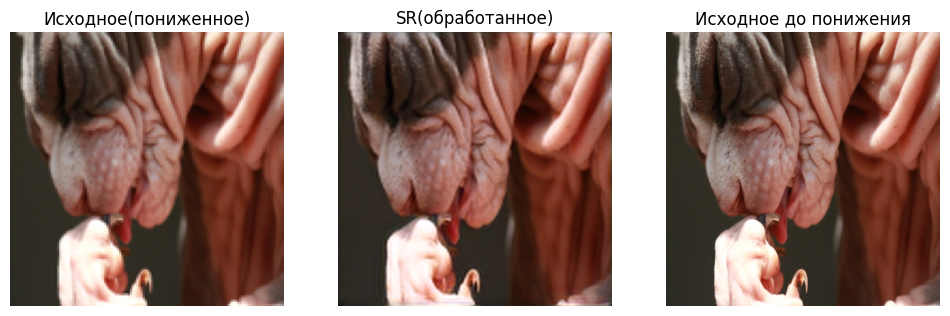

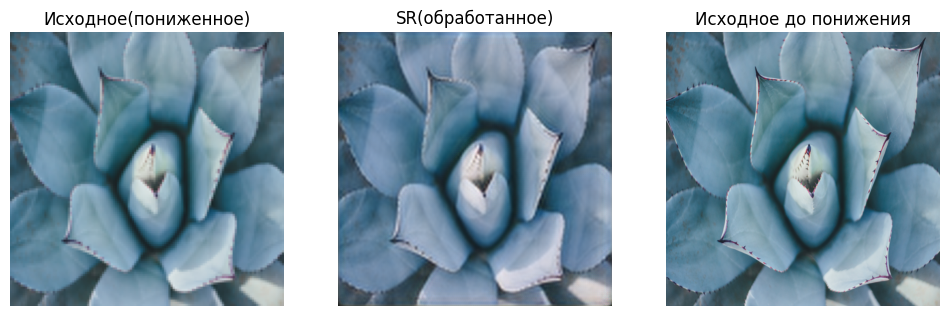

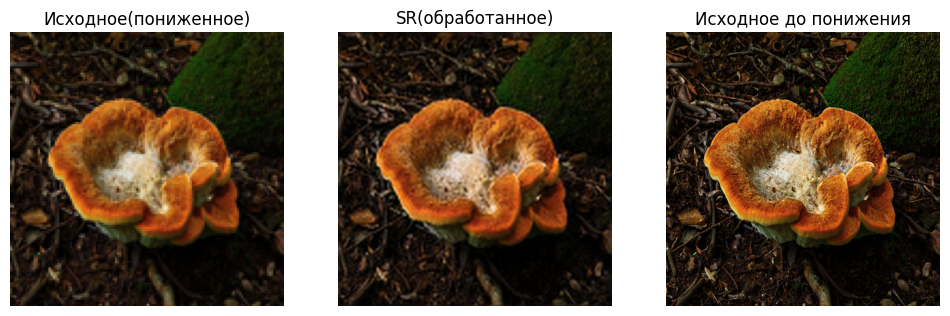

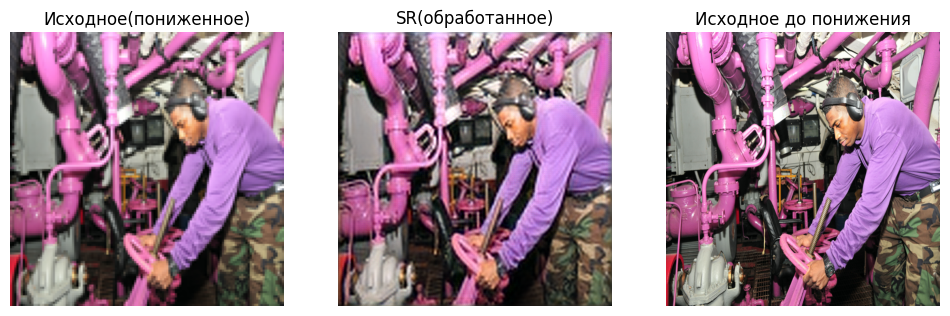

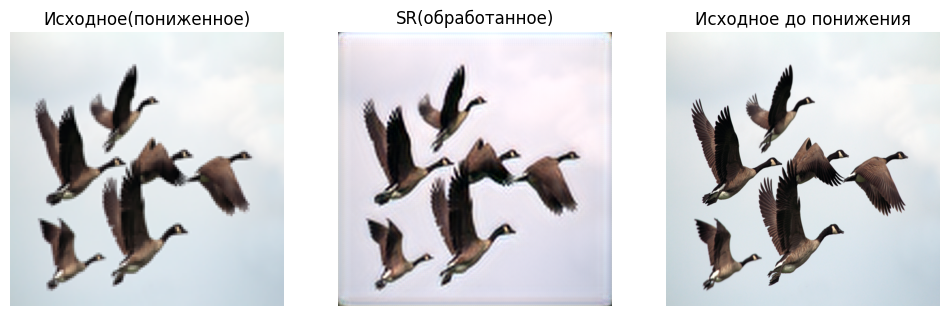

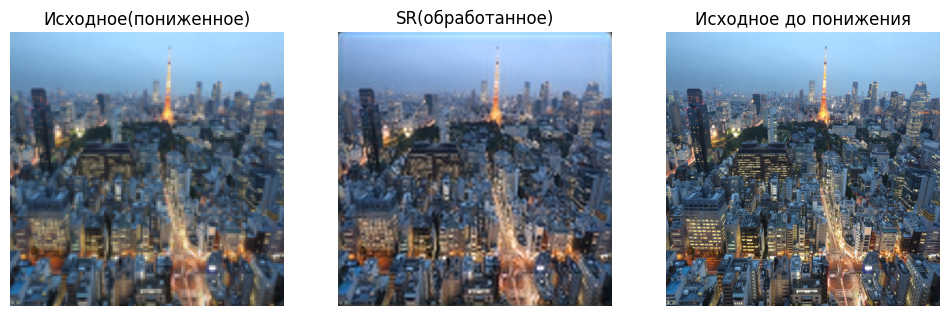

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

for i, (lr, hr) in enumerate(val_dataloader):
    lr = lr.to("cuda")
    with torch.no_grad():
        sr = model(lr)  # супер-резолюция

    # Перевод в CPU и numpy для отображения
    sr_img = sr.cpu()[0]
    hr_img = hr.cpu()[0]
    lr_img = lr.cpu()[0]

    sr_img = TF.to_pil_image(sr_img.clamp(0,1))
    hr_img = TF.to_pil_image(hr_img.clamp(0,1))
    lr_img = TF.to_pil_image(lr_img.clamp(0,1))

    # Отображение
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Исходное(пониженное)")
    plt.imshow(lr_img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("SR(обработанное)")
    plt.imshow(sr_img)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Исходное до понижения")
    plt.imshow(hr_img)
    plt.axis("off")

    plt.show()

    if i == 5:
        break

# Улучшаем архитектуру (путем добавления Attention) и сжатием в 2раза

In [ ]:
dataset = DIV2KDataset(hr_dir=train_hr_dir, hr_size=512, scale=2)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
val_dataset = DIV2KDataset(hr_dir=val_hr_dir, hr_size=512, scale=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
class CBAMBlock(nn.Module):
    def __init__(self, channels=64, reduction=16):
        super().__init__()
        # стандартный Residual
        self.res = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )
        # Channel Attention
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.sa = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.res(x)
        # channel attention
        ca_weight = self.ca(out)
        out = out * ca_weight
        # spatial attention
        max_out, _ = torch.max(out, dim=1, keepdim=True)
        avg_out = torch.mean(out, dim=1, keepdim=True)
        sa_weight = self.sa(torch.cat([max_out, avg_out], dim=1))
        out = out * sa_weight
        return x + out

In [ ]:
class SRResNet(nn.Module):
    def __init__(self, num_blocks=16, scale_factor=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 9, 1, 4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(*[CBAMBlock(64) for _ in range(num_blocks)])
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64)
        )
        self.upsample = nn.Sequential(*[UpsampleBlock(64, 2) for _ in range(scale_factor // 2)])
        self.conv3 = nn.Conv2d(64, 3, 9, 1, 4)

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out = self.conv2(out) + out1
        out = self.upsample(out)
        out = self.conv3(out)
        return out

In [ ]:
model = train_srresnet(dataloader, epochs=10,scale=2, lr=1e-4)

Epoch [1/10] 
Loss: 0.0935


Val Loss: 0.0523
 Лучший показатель на 1 эпохе с Val Loss: 0.0523


Epoch [2/10] 
Loss: 0.0552


Val Loss: 0.0427
 Лучший показатель на 2 эпохе с Val Loss: 0.0427


Epoch [3/10] 
Loss: 0.0441


Val Loss: 0.0383
 Лучший показатель на 3 эпохе с Val Loss: 0.0383


Epoch [4/10] 
Loss: 0.0371


Val Loss: 0.0329
 Лучший показатель на 4 эпохе с Val Loss: 0.0329


Epoch [5/10] 
Loss: 0.0364


Val Loss: 0.0356


Epoch [6/10] 
Loss: 0.0332


Val Loss: 0.0323
 Лучший показатель на 6 эпохе с Val Loss: 0.0323


Epoch [7/10] 
Loss: 0.0318


Val Loss: 0.0285
 Лучший показатель на 7 эпохе с Val Loss: 0.0285


Epoch [8/10] 
Loss: 0.0301


Val Loss: 0.0297


Epoch [9/10] 
Loss: 0.0291


Val Loss: 0.0276
 Лучший показатель на 9 эпохе с Val Loss: 0.0276


Epoch [10/10] 
Loss: 0.0282


Val Loss: 0.0275
 Лучший показатель на 10 эпохе с Val Loss: 0.0275


In [ ]:
model = SRResNet(scale_factor=2).to("cuda")
model.load_state_dict(torch.load("best_srresnet.pth", map_location="cuda"))
model.eval()

SRResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (res_blocks): Sequential(
    (0): CBAMBlock(
      (res): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (ca): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU()
        (3): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
      (sa): Sequential(
        (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): Sigmoid()
      )
    )
    (1): CB

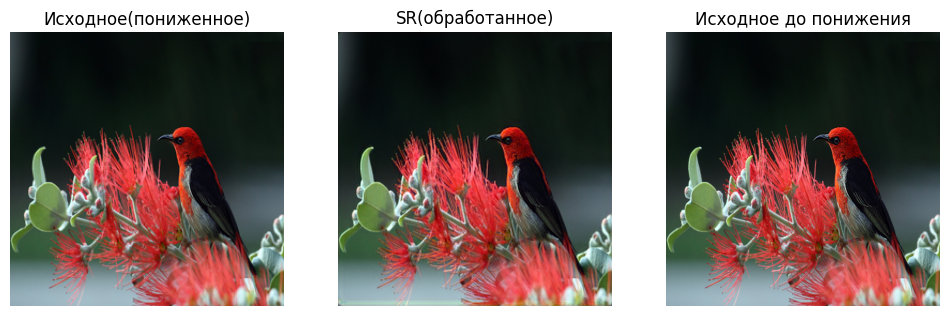

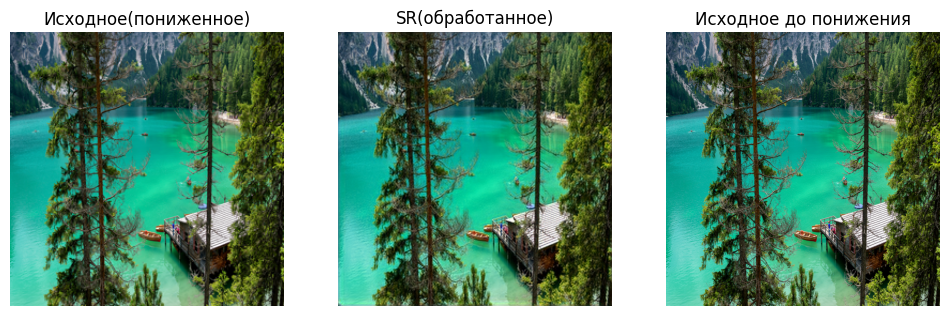

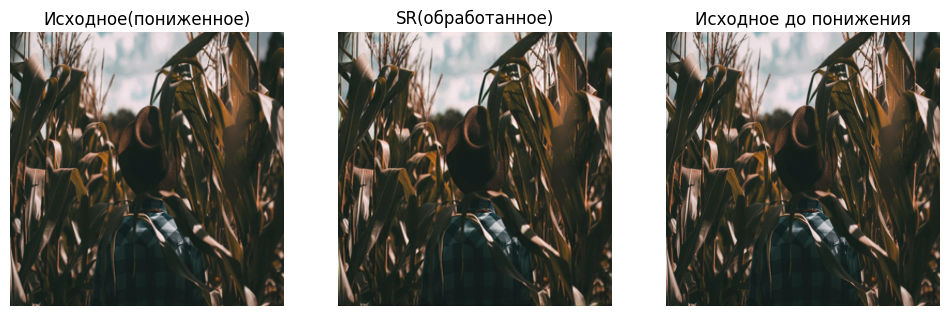

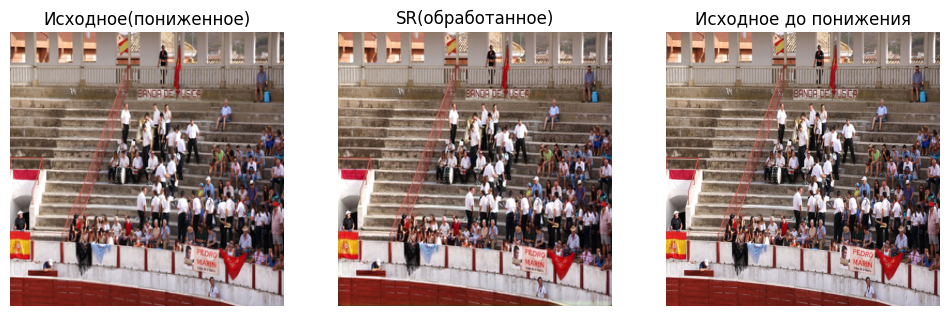

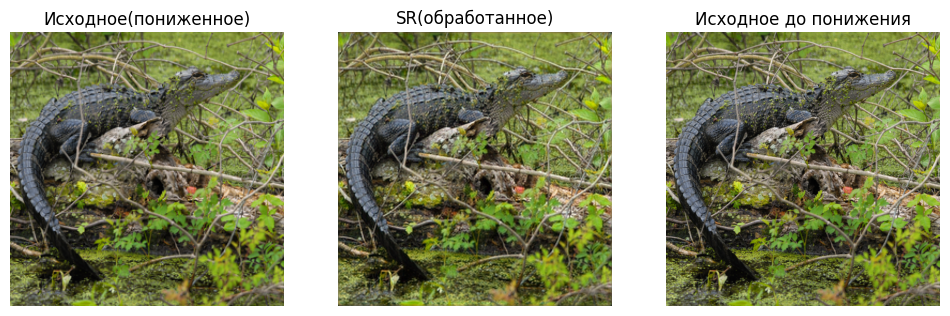

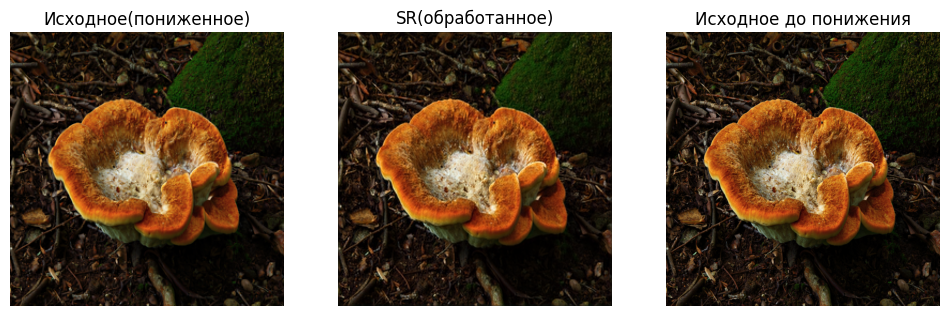

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

for i, (lr, hr) in enumerate(val_dataloader):
    lr = lr.to("cuda")
    with torch.no_grad():
        sr = model(lr)  # супер-резолюция

    # Перевод в CPU и numpy для отображения
    sr_img = sr.cpu()[0]
    hr_img = hr.cpu()[0]
    lr_img = lr.cpu()[0]

    sr_img = TF.to_pil_image(sr_img.clamp(0,1))
    hr_img = TF.to_pil_image(hr_img.clamp(0,1))
    lr_img = TF.to_pil_image(lr_img.clamp(0,1))

    # Отображение
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Исходное(пониженное)")
    plt.imshow(lr_img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("SR(обработанное)")
    plt.imshow(sr_img)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Исходное до понижения")
    plt.imshow(hr_img)
    plt.axis("off")

    plt.show()

    if i == 5:
        break

Здесь измениния видны лишь на мелких деталях

# **Итоги**

Я выбрал SRResNet ибо она и достаточно быстра и дает хорошие результаты.

А по визуальным ощущениям выглядит как 240p - 480-720p - 1080p.

## Основные результаты
- Модель SRResNet успешно повышает разрешение изображений ×2 и ×4
- Добавление CBAM улучшает визуальное качество за счет внимания к каналам и пространству
- Перцептуальная потеря повышает реалистичность текстур

## Проблемы и ограничения
- Требуются большие объемы данных и GPU для обучения
- Артефакты сохраняются на сложных текстурах
- При масштабировании ×4 теряется точность мелких деталей а при масштабировании x2 так как картина изначально выглядит прилично трудно заметить изменения(здесь я ограничен видеопамятью)